# Barcelona Neighbors

In [5]:
import pandas as pd
import folium
import numpy as np

In [3]:
# open
barcelona_stations = pd.read_csv('metro_barcelona_uniques.csv', index_col=0)

In [8]:
print(barcelona_stations.shape)
barcelona_stations.head(10)

(230, 7)


,EQUIPAMENT,NOM_BARRI,Longitude,Latitude,line,name,station
0,"METRO (L3, L5) - VALL D'HEBRON (C. de les Bass...",la Vall d'Hebron,2.142987,41.424923,"METRO (L3, L5)",VALL D'HEBRON (C. de les Basses d'Horta),VALL D'HEBRON
1,FGC - PROVENÇA (C. de Provença)-,l'Antiga Esquerra de l'Eixample,2.158326,41.392331,FGC,PROVENÇA (C. de Provença),PROVENÇA
2,FGC (L6) - REINA ELISENDA (Sortida Duquesa d'O...,Sarrià,2.119370,41.399203,FGC (L6),REINA ELISENDA (Sortida Duquesa d'Orleans),REINA ELISENDA
3,FGC (L6) - LA BONANOVA-,Sant Gervasi - Galvany,2.135427,41.397791,FGC (L6),LA BONANOVA,LA BONANOVA
4,METRO (L11) - CASA DE L'AIGUA (C. Vila-Real)-,la Trinitat Nova,2.185391,41.451492,METRO (L11),CASA DE L'AIGUA (C. Vila,CASA DE L'AIGUA
5,METRO (L11) - CIUTAT MERIDIANA (C. Pedraforca)-,Ciutat Meridiana,2.174473,41.460889,METRO (L11),CIUTAT MERIDIANA (C. Pedraforca),CIUTAT MERIDIANA
6,METRO (L1) - CATALUNYA (Rda. Universitat)-,la Dreta de l'Eixample,2.168588,41.387200,METRO (L1),CATALUNYA (Rda. Universitat),CATALUNYA
9,METRO (L5) - SANT ILDEFONS-,NaN,2.083994,41.362753,METRO (L5),SANT ILDEFONS,SANT ILDEFONS
10,METRO (L2) - MONUMENTAL (C. de la Marina)-,el Fort Pienc,2.179581,41.400180,METRO (L2),MONUMENTAL (C. de la Marina),MONUMENTAL
11,METRO (L1) - ROCAFORT (C. de Rocafort)-,la Nova Esquerra de l'Eixample,2.153966,41.379070,METRO (L1),ROCAFORT (C. de Rocafort),ROCAFORT


## Show stations in a map

In [7]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

mapi = folium.Map(location=[barcelona_stations.Latitude.mean(), barcelona_stations.Longitude.mean()], 
                  zoom_start=12,
                  control_scale = True)
folium.TileLayer('cartodbpositron', attr='igs').add_to(mapi)

# set color scheme for the clusters
n = len(barcelona_stations['line'].unique())
x = np.arange(n)
perro = dict(zip(barcelona_stations['line'].unique(),x))
ys = [i + x + (i*x)**2 for i in range(n)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]



# add markers to the map
markers_colors = []
for lat, lon, poi, line in zip(barcelona_stations['Latitude'], 
                                  barcelona_stations['Longitude'], 
                                  barcelona_stations['station'], 
                                  barcelona_stations['line']):
    label = folium.Popup(str(poi) + ' Line ' + str(line), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=rainbow[perro[line]-1],
        fill=True,
        fill_color=rainbow[int(perro[line])-1],
        fill_opacity=0.7).add_to(mapi)
       
mapi

## Foursquare analysis

In [9]:
CLIENT_ID = 'LMSBMJJP4OW4TX0OGZOZLIBNWRZGPAE21WLWDZYPJPBQTK5Z' # your Foursquare ID
CLIENT_SECRET = 'UDCGEDKOD1FETOKSWXQJBHCOASQRRHBUKTKMPNXW02PW4XVJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 500

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LMSBMJJP4OW4TX0OGZOZLIBNWRZGPAE21WLWDZYPJPBQTK5Z
CLIENT_SECRET:UDCGEDKOD1FETOKSWXQJBHCOASQRRHBUKTKMPNXW02PW4XVJ


In [10]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT = 500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Get the venues in barcelona in 500 radius

In [12]:
barcelona_venues = getNearbyVenues(barcelona_stations['station'] + '/' + barcelona_stations['line'], 
                                 barcelona_stations['Latitude'], 
                                 barcelona_stations['Longitude'], 
                                 radius=500)

VALL D'HEBRON/METRO (L3, L5)
PROVENÇA/FGC
REINA ELISENDA/FGC (L6)
LA BONANOVA/FGC (L6)
CASA DE L'AIGUA/METRO (L11)
CIUTAT MERIDIANA/METRO (L11)
CATALUNYA/METRO (L1)
SANT ILDEFONS/METRO (L5)
MONUMENTAL/METRO (L2)
ROCAFORT/METRO (L1)
PASSEIG DE GRÀCIA/METRO (L2)
RAMBLA JUST OLIVERAS/METRO (L1)
HORTA/METRO (L5)
CA N'OLIVERES/TRAMVIA (T1,T2,T3)
ESPRONCEDA/TRAMVIA (T5, T6)
AVINGUDA DE XILE/TRAMVIA (T1,T2,T3)
CAN RIGAL/TRAMVIA (T1,T2,T3)
ENCANTS DE SANT ADRIÀ/TRAMVIA (T5)
FÒRUM/TRAMVIA (T4)
ESTACIÓ DE SANT ADRIÀ/TRAMVIA (T4, T6)
FONTSANTA/TRAMVIA (T1,T2)
nan
MONTCADA/RENFE
MERCAT NOU/METRO (L1)
TARRAGONA/METRO (L3)
MUNDET/METRO (L3)
EL MARESME/METRO (L4)
UNIVERSITAT/METRO (L2)
EL PEDRÒ/TRAMVIA (T1,T2)
EL PRAT DE LLOBREGAT/RENFE
EUROPA / FIRA/FGC (L8)
MARIA CRISTINA/METRO (L3)
VIA JÚLIA/METRO (L4)
SANTS ESTACIÓ/METRO (L3)
GIRONA/METRO (L4)
LLUCMAJOR/METRO (L4)
BADAL/METRO (L5)
POBLENOU/METRO (L4)
CONGRÉS/METRO (L5)
ESPANYA/METRO (L3)
PUBILLA CASES/METRO (L5)
EL CARMEL/METRO (L5)
CORNELLÀ CENT

In [14]:
print(barcelona_venues.shape)
barcelona_venues = barcelona_venues.rename(columns={'Neighborhood':'stations',
                              'Neighborhood Latitude':'stations Latitude',
                              'Neighborhood Longitude':'stations Longitude'})
barcelona_venues.head()

(8988, 7)


,stations,stations Latitude,stations Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"VALL D'HEBRON/METRO (L3, L5)",41.424923,2.142987,Camp Hebron-Teixonera,41.425532,2.146341,Soccer Field
1,"VALL D'HEBRON/METRO (L3, L5)",41.424923,2.142987,Bar Plaza,41.421942,2.141679,Spanish Restaurant
2,"VALL D'HEBRON/METRO (L3, L5)",41.424923,2.142987,Bar Smith,41.424204,2.147051,Bar
3,"VALL D'HEBRON/METRO (L3, L5)",41.424923,2.142987,Caprabo,41.424942,2.140979,Grocery Store
4,"VALL D'HEBRON/METRO (L3, L5)",41.424923,2.142987,Mercat de Vall d'Hebron,41.424229,2.142355,Farmers Market


### Saving data

In [15]:
#it is important nto save this, because we do not want to use FourSquare again to get the data
barcelona_venues.to_csv('barcelona_venues.csv')

### Load data

In [ ]:
barcelona_venues.read_csv('barcelona_venues.csv', index_col=0)

Removing train stations and metro stations

In [22]:
barcelona_venues[barcelona_venues['Venue Category'].str.contains('Station')]['Venue Category'].unique()

array(['Bus Station', 'Train Station', 'Metro Station', 'Tram Station',
       'Light Rail Station', 'Gas Station'], dtype=object)

In [24]:
# we will remove train station, metro station and light rail station
barcelona_venues = barcelona_venues[barcelona_venues['Venue Category'] != 'Train Station']
barcelona_venues = barcelona_venues[barcelona_venues['Venue Category'] != 'Metro Station']
barcelona_venues = barcelona_venues[barcelona_venues['Venue Category'] != 'Tram Station']
barcelona_venues = barcelona_venues[barcelona_venues['Venue Category'] != 'Light Rail Station']
barcelona_venues.shape

(8847, 7)

### Venues by station

In [27]:
venues_per_station = barcelona_venues.groupby('stations').count()\
    .sort_values(by='Venue', ascending=False)\
    .reset_index().iloc[:,0:2].rename(columns = {'stations Latitude':'n'})

In [28]:
venues_per_station

,stations,n
0,DIAGONAL/METRO (L3),100
1,URQUINAONA/METRO (L4),100
2,SANT PAU/METRO (L5),100
3,SANT GERVASI/FGC,100
4,FONTANA/METRO (L3),100
5,DRASSANES/METRO (L3),100
6,SANT ANTONI/METRO (L2),100
7,"FRANCESC MACIÀ/TRAMVIA (T1,T2,T3)",100
8,TETUAN/METRO (L2),100
9,CATALUNYA/METRO (L1),100


In [33]:
print(venues_per_station[venues_per_station['n']<10].shape)
venues_per_station[venues_per_station['n']<10]

(39, 2)


,stations,n
190,"BON PASTOR/METRO (L9, L10)",9
191,EL CARMEL/METRO (L5),9
192,SANT JOAN BAPTISTA/TRAMVIA (T5),9
193,SANT ILDEFONS/METRO (L5),9
194,"CAN RIGAL/TRAMVIA (T1,T2,T3)",9
195,LLEFIÀ/METRO (L10),8
196,EL COLL / LA TEIXONERA/METRO (L5),8
197,COLÒNIA GÜELL/FGC,7
198,CAN PEIXAUET/METRO (L9),7
199,TRINITAT NOVA/METRO (L3),7


In [35]:
stations_to_remove = venues_per_station[venues_per_station['n']<10]['stations'].apply(lambda x: x.split('/')[0])
stations = barcelona_stations[barcelona_stations['station'].isin(stations_to_remove.to_list())]

In [40]:
mapi = folium.Map(location=[stations.Latitude.mean(), stations.Longitude.mean()], 
                  zoom_start=11,
                  control_scale = True)
#folium.TileLayer('cartodbpositron', attr='igs').add_to(mapi)

# set color scheme for the clusters
n = len(stations['line'].unique())
x = np.arange(n)
perro = dict(zip(stations['line'].unique(),x))
ys = [i + x + (i*x)**2 for i in range(n)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]



# add markers to the map
markers_colors = []
for lat, lon, poi, line in zip(stations['Latitude'], 
                                  stations['Longitude'], 
                                  stations['station'], 
                                  stations['line']):
    label = folium.Popup(str(poi) + ' Line ' + str(line), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[perro[line]-1],
        fill=True,
        fill_color=rainbow[int(perro[line])-1],
        fill_opacity=0.7).add_to(mapi)
       
mapi

We decide not to remove the stations with less than 10 venues

In [41]:
barcelona_venues[barcelona_venues['stations'] == 'CAN BOIXERES/METRO (L5)']

,stations,stations Latitude,stations Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
4044,CAN BOIXERES/METRO (L5),41.366055,2.090782,Poliesportiu Municipal Sanfeliu,41.368874,2.089014,Gym
4045,CAN BOIXERES/METRO (L5),41.366055,2.090782,El Olivero Gueno,41.363624,2.091428,Bar
4046,CAN BOIXERES/METRO (L5),41.366055,2.090782,Cebicheria PUNTOPE,41.364025,2.086504,Peruvian Restaurant
4047,CAN BOIXERES/METRO (L5),41.366055,2.090782,McDonald's,41.370132,2.090401,Fast Food Restaurant
4048,CAN BOIXERES/METRO (L5),41.366055,2.090782,Camp Futbol Can Boixeres,41.366658,2.096075,Soccer Field


In [42]:
print('There are {} uniques categories.'.format(len(barcelona_venues['Venue Category'].unique())))

There are 334 uniques categories.


## Analize each station

### One hot encoding

In [43]:
# one hot encoding
barcelona_onehot = pd.get_dummies(barcelona_venues[['Venue Category']], prefix="", prefix_sep="")
cols = list(barcelona_onehot.columns)
barcelona_onehot.shape

(8847, 334)

In [48]:
cols = list(barcelona_onehot.columns)
barcelona_onehot['station'] = barcelona_venues.stations
barcelona_onehot = barcelona_onehot[['station'] + cols]
barcelona_onehot.head()

,station,Accessories Store,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,...,Venezuelan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio,Zoo
0,"VALL D'HEBRON/METRO (L3, L5)",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"VALL D'HEBRON/METRO (L3, L5)",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"VALL D'HEBRON/METRO (L3, L5)",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"VALL D'HEBRON/METRO (L3, L5)",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"VALL D'HEBRON/METRO (L3, L5)",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Group by station

In [49]:
barcelona_onehot_grouped = barcelona_onehot.groupby('station').mean().reset_index()
barcelona_onehot_grouped.head()

,station,Accessories Store,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,...,Venezuelan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio,Zoo
0,AEROPORT/Tren AEROPORT,0.000000,0.0,0.032258,0.032258,0.096774,0.032258,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032258,0.000000,0.0
1,"ALFONS EL MAGNÀNIM/TRAMVIA (T5, T6)",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,ALFONS X/METRO (L4),0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3,ALMEDA/FGC,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
4,ARC DE TRIOMF/RENFE,0.013333,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.013333,0.0


In [50]:
barcelona_onehot_grouped.shape

(229, 335)

In [51]:
num_top_venues = 10

def print_most_common_list(data_grouped, hood, num_top):
    print("----"+hood+"----")
    temp = data_grouped[data_grouped['station'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top))
    print('\n')

In [52]:
for hood in barcelona_onehot_grouped['station']:
    print_most_common_list(barcelona_onehot_grouped, hood, num_top_venues)

----AEROPORT/Tren AEROPORT----
                           venue  freq
0            Rental Car Location  0.19
1                Airport Service  0.10
2                         Bakery  0.06
3                           Café  0.06
4                 Clothing Store  0.06
5               Airport Terminal  0.03
6  Vegetarian / Vegan Restaurant  0.03
7                    Coffee Shop  0.03
8                            Bar  0.03
9           Fast Food Restaurant  0.03


----ALFONS EL MAGNÀNIM/TRAMVIA (T5, T6)----
                venue  freq
0       Big Box Store  0.09
1   Food & Drink Shop  0.09
2  Spanish Restaurant  0.09
3        Climbing Gym  0.09
4    Tapas Restaurant  0.09
5                Café  0.09
6       Grocery Store  0.09
7          Skate Park  0.09
8         Supermarket  0.09
9              Bakery  0.09


----ALFONS X/METRO (L4)----
                venue  freq
0                Café  0.12
1       Grocery Store  0.09
2  Chinese Restaurant  0.07
3              Bakery  0.07
4    Tapas Resta

                      venue  freq
0                Restaurant  0.22
1                      Café  0.22
2             Grocery Store  0.11
3                    Bakery  0.11
4        Athletics & Sports  0.11
5        Italian Restaurant  0.11
6  Mediterranean Restaurant  0.11
7         Paella Restaurant  0.00
8               Pastry Shop  0.00
9                      Park  0.00


----BON VIATGE/TRAMVIA (T1,T2)----
                      venue  freq
0          Tapas Restaurant  0.20
1             Grocery Store  0.13
2                Restaurant  0.07
3             Hot Dog Joint  0.07
4            Farmers Market  0.07
5  Mediterranean Restaurant  0.07
6                      Café  0.07
7               Pizza Place  0.07
8                       Bar  0.07
9                 Wine Shop  0.07


----BONANOVA/FGC----
                      venue  freq
0        Italian Restaurant  0.10
1       Japanese Restaurant  0.10
2                Restaurant  0.10
3                      Café  0.07
4                    B

                       venue  freq
0         Spanish Restaurant  0.23
1                       Park  0.15
2                  Cafeteria  0.08
3               Tennis Court  0.08
4          Convenience Store  0.08
5  Latin American Restaurant  0.08
6                Pizza Place  0.08
7                Supermarket  0.08
8                     Bakery  0.08
9           Tapas Restaurant  0.08


----CERDANYOLA DEL VALLÈS/RENFE----
                      venue  freq
0             Grocery Store  0.13
1                      Café  0.09
2  Mediterranean Restaurant  0.09
3               Pizza Place  0.09
4         Outdoor Sculpture  0.04
5                 Multiplex  0.04
6                    Bakery  0.04
7          Tapas Restaurant  0.04
8             Shopping Mall  0.04
9         Food & Drink Shop  0.04


----CIUTADELLA/TRAMVIA (T4)----
                       venue  freq
0                  Nightclub  0.10
1         Spanish Restaurant  0.06
2                       Café  0.06
3                 Restaurant 

                      venue  freq
0                     Hotel  0.08
1  Mediterranean Restaurant  0.08
2                      Café  0.06
3             Grocery Store  0.06
4                Restaurant  0.06
5               Supermarket  0.06
6        Spanish Restaurant  0.06
7        Mexican Restaurant  0.04
8      Gym / Fitness Center  0.04
9            Breakfast Spot  0.04


----ESGLÉSIA MAJOR/METRO (L9)----
                venue  freq
0          Restaurant  0.13
1                 Bar  0.13
2    Tapas Restaurant  0.10
3  Italian Restaurant  0.07
4        Cupcake Shop  0.03
5         Snack Place  0.03
6                Café  0.03
7          Steakhouse  0.03
8                Food  0.03
9         Supermarket  0.03


----ESPANYA/METRO (L3)----
                 venue  freq
0           Restaurant  0.08
1                Plaza  0.08
2     Tapas Restaurant  0.08
3                Hotel  0.06
4   Seafood Restaurant  0.04
5          Coffee Shop  0.04
6                  Gym  0.04
7  Peruvian Restauran

                    venue  freq
0             Supermarket  0.11
1                     Gym  0.11
2          Farmers Market  0.06
3        Swiss Restaurant  0.06
4                Pharmacy  0.06
5                    Park  0.06
6        Tapas Restaurant  0.06
7  Argentinian Restaurant  0.06
8              Restaurant  0.06
9             Pizza Place  0.06


----HOSTAFRANCS/METRO (L1)----
                       venue  freq
0           Tapas Restaurant  0.08
1                Pizza Place  0.08
2                      Hotel  0.06
3   Mediterranean Restaurant  0.05
4                        Bar  0.05
5                     Bakery  0.05
6         Italian Restaurant  0.03
7  Middle Eastern Restaurant  0.03
8              Hot Dog Joint  0.03
9         Spanish Restaurant  0.03


----IGNASI IGLÉSIAS/TRAMVIA (T1,T2)----
                      venue  freq
0          Tapas Restaurant  0.22
1                       Bar  0.11
2               Pizza Place  0.11
3                Restaurant  0.06
4                 

                           venue  freq
0                      BBQ Joint   0.5
1                     Restaurant   0.5
2              Outdoor Sculpture   0.0
3                    Pastry Shop   0.0
4                           Park   0.0
5  Paper / Office Supplies Store   0.0
6                         Palace   0.0
7           Pakistani Restaurant   0.0
8              Paella Restaurant   0.0
9                   Outlet Store   0.0


----LES TRES TORRES/FGC (L6)----
                      venue  freq
0                     Hotel  0.10
1               Pizza Place  0.07
2                Restaurant  0.07
3          Pedestrian Plaza  0.07
4  Mediterranean Restaurant  0.07
5              Burger Joint  0.07
6        Spanish Restaurant  0.07
7          Sushi Restaurant  0.03
8                       Gym  0.03
9             Grocery Store  0.03


----LES TRES TORRES<center>/FGC----
                      venue  freq
0                     Hotel  0.10
1               Pizza Place  0.07
2                Resta

                      venue  freq
0  Mediterranean Restaurant  0.08
1        Italian Restaurant  0.06
2        Spanish Restaurant  0.04
3       Japanese Restaurant  0.04
4             Deli / Bodega  0.04
5                      Café  0.04
6             Grocery Store  0.04
7                     Hotel  0.03
8         Electronics Store  0.03
9                Restaurant  0.03


----Miramar/Transbordador del Port----
                      venue  freq
0                     Hotel  0.10
1                    Hostel  0.07
2                     Plaza  0.05
3                 Nightclub  0.05
4                      Park  0.05
5          Tapas Restaurant  0.05
6                   Theater  0.03
7            Sandwich Place  0.03
8            Scenic Lookout  0.03
9  Mediterranean Restaurant  0.03


----Mª CRISTINA/TRAMVIA (T1,T2,T3)----
                           venue  freq
0                     Restaurant  0.12
1             Spanish Restaurant  0.09
2                          Hotel  0.05
3             

                      venue  freq
0  Mediterranean Restaurant  0.08
1        Spanish Restaurant  0.07
2        Italian Restaurant  0.05
3                Restaurant  0.05
4               Pizza Place  0.05
5                     Hotel  0.04
6                      Café  0.04
7                    Bakery  0.03
8              Cocktail Bar  0.03
9          Tapas Restaurant  0.03


----PONT D'ESPLUGUES/TRAMVIA (T1,T2,T3)----
                      venue  freq
0               Coffee Shop  0.10
1            Ice Cream Shop  0.10
2                    Bakery  0.10
3               Supermarket  0.07
4          Tapas Restaurant  0.07
5               Pizza Place  0.07
6  Mediterranean Restaurant  0.07
7                Bagel Shop  0.03
8        Spanish Restaurant  0.03
9         Food & Drink Shop  0.03


----PORT FÒRUM/TRAMVIA (T4, T6)----
                           venue  freq
0                            Gym  0.17
1                      Nightclub  0.17
2       Mediterranean Restaurant  0.17
3           

                      venue  freq
0                     Hotel  0.16
1              Burger Joint  0.11
2             Grocery Store  0.11
3               IT Services  0.05
4               Coffee Shop  0.05
5        Spanish Restaurant  0.05
6               Supermarket  0.05
7                      Café  0.05
8          Tapas Restaurant  0.05
9  Mediterranean Restaurant  0.05


----SANT MARTÍ DE PROVENÇALS/TRAMVIA (T5, T6)----
              venue  freq
0      Soccer Field  0.08
1     Grocery Store  0.08
2       Coffee Shop  0.08
3  Tapas Restaurant  0.08
4       Pizza Place  0.08
5            Bakery  0.08
6      Tennis Court  0.04
7    Farmers Market  0.04
8  Asian Restaurant  0.04
9      Liquor Store  0.04


----SANT MARTÍ/METRO (L2)----
                      venue  freq
0               Coffee Shop  0.10
1          Tapas Restaurant  0.10
2                      Park  0.07
3             Grocery Store  0.07
4                    Bakery  0.07
5              Soccer Field  0.07
6               Pi

                           venue  freq
0             Spanish Restaurant  0.14
1                           Park  0.14
2                       Pharmacy  0.14
3               Tapas Restaurant  0.14
4                  Grocery Store  0.14
5                 Breakfast Spot  0.14
6                    Music Venue  0.14
7              Outdoor Sculpture  0.00
8  Paper / Office Supplies Store  0.00
9                         Palace  0.00


----TRINITAT VELLA/METRO (L1)----
                  venue  freq
0      Tapas Restaurant   0.2
1    Spanish Restaurant   0.2
2                 Plaza   0.2
3          Soccer Field   0.2
4                  Park   0.2
5     Accessories Store   0.0
6                Palace   0.0
7  Pakistani Restaurant   0.0
8     Paella Restaurant   0.0
9          Outlet Store   0.0


----Terminal Marítima A *Creuers/Terminal Marítima A *Creuers----
                           venue  freq
0                  Boat or Ferry  0.47
1                         Cruise  0.35
2                   

                      venue  freq
0  Mediterranean Restaurant  0.12
1        Spanish Restaurant  0.12
2                Restaurant  0.12
3       Sporting Goods Shop  0.06
4        Chinese Restaurant  0.06
5          Football Stadium  0.06
6               Supermarket  0.06
7              Outlet Store  0.06
8                      Café  0.06
9      Fast Food Restaurant  0.06


----WELLINGTON/TRAMVIA (T4)----
                      venue  freq
0                      Café  0.10
1        Spanish Restaurant  0.07
2               Coffee Shop  0.07
3               Supermarket  0.06
4              Burger Joint  0.04
5               Pizza Place  0.04
6                    Bakery  0.04
7                Restaurant  0.04
8  Mediterranean Restaurant  0.04
9            Breakfast Spot  0.03


----ZONA UNIVERSITÀRIA/METRO (L3)----
                  venue  freq
0  Gym / Fitness Center  0.09
1                   Bar  0.09
2             Nightclub  0.09
3            Restaurant  0.09
4           Sports Club  0.0

### Put most common venues in dataframe 

In [163]:
#First, let's write a function to sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#Now let's create the new dataframe and display the top 10 venues for each neighborhood.

import numpy as np

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
stations_venues_sorted = pd.DataFrame(columns=columns)
stations_venues_sorted['station'] = barcelona_onehot_grouped['station']

for ind in np.arange(barcelona_onehot_grouped.shape[0]):
    stations_venues_sorted.iloc[ind, 1:] = return_most_common_venues(barcelona_onehot_grouped.iloc[ind, :], num_top_venues)

stations_venues_sorted.head()

,station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,AEROPORT/Tren AEROPORT,Rental Car Location,Airport Service,Clothing Store,Bakery,Café,Dessert Shop,Duty-free Shop,Coffee Shop,Public Art,Bus Stop
1,"ALFONS EL MAGNÀNIM/TRAMVIA (T5, T6)",Spanish Restaurant,Supermarket,Bakery,Grocery Store,Tapas Restaurant,Diner,Café,Climbing Gym,Big Box Store,Skate Park
2,ALFONS X/METRO (L4),Café,Grocery Store,Bakery,Tapas Restaurant,Chinese Restaurant,Park,Gym,Spanish Restaurant,Latin American Restaurant,Supermarket
3,ALMEDA/FGC,Mediterranean Restaurant,Coffee Shop,Diner,Tapas Restaurant,Café,Pizza Place,Department Store,Sandwich Place,Big Box Store,Park
4,ARC DE TRIOMF/RENFE,Hotel,Coffee Shop,Bistro,Mediterranean Restaurant,Hostel,Chinese Restaurant,Gym,Restaurant,Breakfast Spot,Pizza Place


## Clustering

In [164]:
# set number of clusters
kclusters = 6

barcelona_grouped_clustering = barcelona_onehot_grouped.drop('station', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(barcelona_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 2, 3, 3, 2, 4, 2, 3, 3, 3])

Insert cluster labels

In [165]:
# add clustering labels
stations_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

barcelona_merged = barcelona_stations.iloc[:,1:]
barcelona_merged['station'] = barcelona_stations['station'] + '/' + barcelona_stations['line']

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
barcelona_merged = barcelona_merged.join(stations_venues_sorted.set_index('station'), on='station')

barcelona_merged.head() # check the last columns!

,NOM_BARRI,Longitude,Latitude,line,name,station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,la Vall d'Hebron,2.142987,41.424923,"METRO (L3, L5)",VALL D'HEBRON (C. de les Basses d'Horta),"VALL D'HEBRON/METRO (L3, L5)",2.0,Spanish Restaurant,Soccer Stadium,Grocery Store,Farmers Market,Bus Station,Soccer Field,Stadium,Basketball Court,Bar,Bakery
1,l'Antiga Esquerra de l'Eixample,2.158326,41.392331,FGC,PROVENÇA (C. de Provença),PROVENÇA/FGC,2.0,Hotel,Spanish Restaurant,Mediterranean Restaurant,Cocktail Bar,Hostel,Burger Joint,Restaurant,Tapas Restaurant,Sandwich Place,Boutique
2,Sarrià,2.119370,41.399203,FGC (L6),REINA ELISENDA (Sortida Duquesa d'Orleans),REINA ELISENDA/FGC (L6),3.0,Café,Breakfast Spot,Bakery,Restaurant,Burger Joint,Tapas Restaurant,Mediterranean Restaurant,Diner,Dessert Shop,Pedestrian Plaza
3,Sant Gervasi - Galvany,2.135427,41.397791,FGC (L6),LA BONANOVA,LA BONANOVA/FGC (L6),3.0,Japanese Restaurant,Restaurant,Italian Restaurant,Café,Salad Place,Gastropub,Bakery,Plaza,Burger Joint,Bistro
4,la Trinitat Nova,2.185391,41.451492,METRO (L11),CASA DE L'AIGUA (C. Vila,CASA DE L'AIGUA/METRO (L11),2.0,Spanish Restaurant,Breakfast Spot,Grocery Store,Pharmacy,Park,Fondue Restaurant,Flower Shop,Empanada Restaurant,Ethiopian Restaurant,Food & Drink Shop


In [166]:
barcelona_merged = barcelona_merged.drop('NOM_BARRI',1)
barcelona_merged = barcelona_merged.dropna()
barcelona_merged.astype({'Cluster Labels':'int32'}, inplace =True)

print(barcelona_merged.shape)

(229, 16)


In [167]:
barcelona_merged = barcelona_merged.astype({'Cluster Labels':'int32'})
barcelona_merged.head()

,Longitude,Latitude,line,name,station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2.142987,41.424923,"METRO (L3, L5)",VALL D'HEBRON (C. de les Basses d'Horta),"VALL D'HEBRON/METRO (L3, L5)",2,Spanish Restaurant,Soccer Stadium,Grocery Store,Farmers Market,Bus Station,Soccer Field,Stadium,Basketball Court,Bar,Bakery
1,2.158326,41.392331,FGC,PROVENÇA (C. de Provença),PROVENÇA/FGC,2,Hotel,Spanish Restaurant,Mediterranean Restaurant,Cocktail Bar,Hostel,Burger Joint,Restaurant,Tapas Restaurant,Sandwich Place,Boutique
2,2.119370,41.399203,FGC (L6),REINA ELISENDA (Sortida Duquesa d'Orleans),REINA ELISENDA/FGC (L6),3,Café,Breakfast Spot,Bakery,Restaurant,Burger Joint,Tapas Restaurant,Mediterranean Restaurant,Diner,Dessert Shop,Pedestrian Plaza
3,2.135427,41.397791,FGC (L6),LA BONANOVA,LA BONANOVA/FGC (L6),3,Japanese Restaurant,Restaurant,Italian Restaurant,Café,Salad Place,Gastropub,Bakery,Plaza,Burger Joint,Bistro
4,2.185391,41.451492,METRO (L11),CASA DE L'AIGUA (C. Vila,CASA DE L'AIGUA/METRO (L11),2,Spanish Restaurant,Breakfast Spot,Grocery Store,Pharmacy,Park,Fondue Restaurant,Flower Shop,Empanada Restaurant,Ethiopian Restaurant,Food & Drink Shop


## Visualizing the clusters

In [168]:
# create map of Barcelona using latitude and longitude mean values
def show_in_map(data, k):
    map_clusters = folium.Map(location=[data.Latitude.mean(), data.Longitude.mean()], 
                              zoom_start=11, control_scale=True)

    # set color scheme for the clusters
    x = np.arange(k)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(data['Latitude'], 
                                      data['Longitude'], 
                                      data['station'], 
                                      data['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)

    return map_clusters
    
show_in_map(barcelona_merged, kclusters)

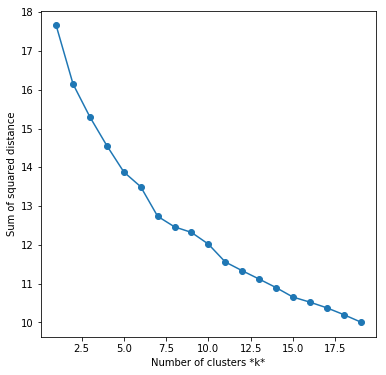

In [169]:
import matplotlib.pyplot as plt

# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 20))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(barcelona_grouped_clustering)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

plt.show()

## Boxplots

In [170]:
barcelona_onehot_grouped_sum = barcelona_onehot.groupby('station').sum().reset_index()
barcelona_onehot_grouped_sum.head()

,station,Accessories Store,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,...,Venezuelan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio,Zoo
0,AEROPORT/Tren AEROPORT,0,0,1,1,3,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,"ALFONS EL MAGNÀNIM/TRAMVIA (T5, T6)",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ALFONS X/METRO (L4),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ALMEDA/FGC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ARC DE TRIOMF/RENFE,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [171]:
ordered_columns = barcelona_onehot_grouped_sum.sum()[1:].sort_values(ascending=False).index.to_list()
barcelona_onehot_sorted = barcelona_onehot_grouped_sum[['station'] + ordered_columns]

In [172]:
barcelona_onehot_sorted.iloc[:,1:] = barcelona_onehot_sorted.iloc[:,1:].apply(lambda x: x/x.max(), axis=0)

In [173]:
barcelona_onehot_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
barcelona_onehot_sorted.head()

,Cluster Labels,station,Tapas Restaurant,Hotel,Mediterranean Restaurant,Restaurant,Spanish Restaurant,Café,Bar,Bakery,...,Street Art,Perfume Shop,Burrito Place,Shabu-Shabu Restaurant,Shopping Plaza,Harbor / Marina,Souvenir Shop,Filipino Restaurant,Church,General Entertainment
0,3,AEROPORT/Tren AEROPORT,0.000000,0.000000,0.000000,0.0,0.0,0.250,0.1,0.250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,"ALFONS EL MAGNÀNIM/TRAMVIA (T5, T6)",0.058824,0.000000,0.000000,0.0,0.1,0.125,0.0,0.125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,ALFONS X/METRO (L4),0.176471,0.000000,0.000000,0.1,0.2,0.625,0.0,0.375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,ALMEDA/FGC,0.117647,0.041667,0.666667,0.1,0.1,0.250,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,ARC DE TRIOMF/RENFE,0.058824,0.250000,0.333333,0.3,0.2,0.250,0.1,0.125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [174]:
import seaborn as sns

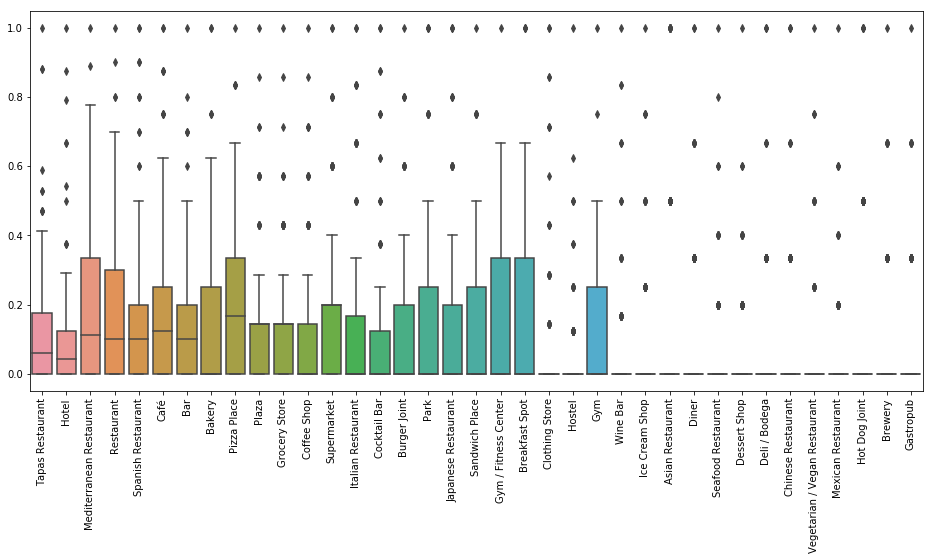

In [175]:
f, axes = plt.subplots(1, 1, figsize=(16, 7))
sns.boxplot(ax=axes,data=barcelona_onehot_sorted.iloc[:,2:39])
plt.xticks(rotation=90)
plt.show()


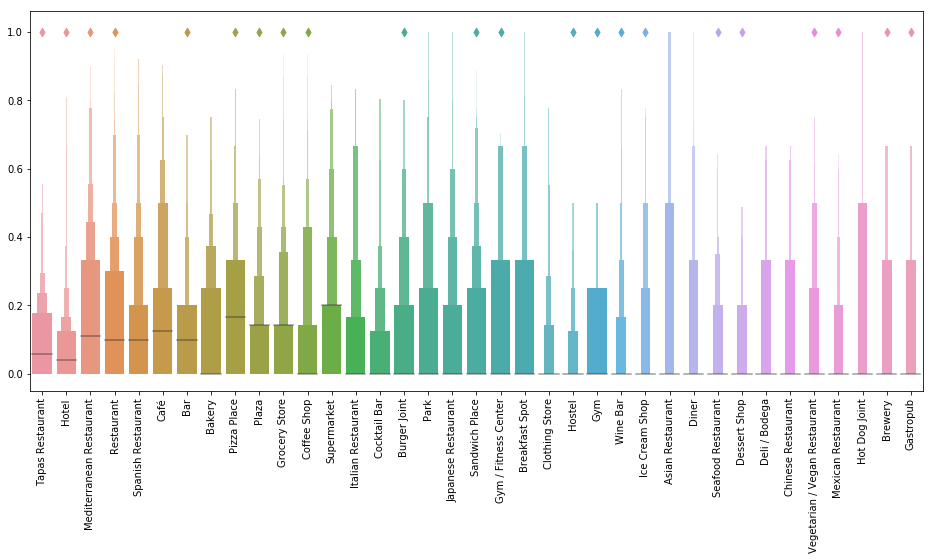

In [176]:
f, axes = plt.subplots(1, 1, figsize=(16, 7))
sns.boxenplot(ax=axes,data=barcelona_onehot_sorted.iloc[:,2:39])
plt.xticks(rotation=90)
plt.show()

We join the columns that are the same

In [177]:
#madrid_onehot_grouped_sum.head()
barcelona_onehot_grouped_sum_refine = barcelona_onehot_grouped_sum
barcelona_onehot_grouped_sum_refine = barcelona_onehot_grouped_sum_refine.drop(columns=['Spanish Restaurant',
                                               'Restaurant',
                                               'Café',
                                               'Coffee Shop',
                                               'Gym / Fitness Center',
                                               'Gym'])
barcelona_onehot_grouped_sum_refine['Restaurant'] = barcelona_onehot_grouped_sum['Spanish Restaurant'] +\
                                                barcelona_onehot_grouped_sum['Restaurant']

barcelona_onehot_grouped_sum_refine['Coffe Shop'] = barcelona_onehot_grouped_sum['Café'] +\
                                                barcelona_onehot_grouped_sum['Coffee Shop']

barcelona_onehot_grouped_sum_refine['Gym'] = barcelona_onehot_grouped_sum['Gym / Fitness Center'] +\
                                                barcelona_onehot_grouped_sum['Gym']

In [178]:
#Sort new dataframe
ordered_columns = barcelona_onehot_grouped_sum_refine.sum()[1:].sort_values(ascending=False).index.to_list()
barcelona_onehot_sorted = barcelona_onehot_grouped_sum_refine[['station'] + ordered_columns]

#normalize
barcelona_onehot_sorted.iloc[:,1:] = barcelona_onehot_sorted.iloc[:,1:].apply(lambda x: x/x.max(), axis=0)

In [179]:
barcelona_onehot_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
barcelona_onehot_sorted.head()

,Cluster Labels,station,Restaurant,Coffe Shop,Tapas Restaurant,Hotel,Mediterranean Restaurant,Bar,Bakery,Pizza Place,...,Post Office,Burrito Place,Memorial Site,Garden Center,Vacation Rental,Gas Station,Lingerie Store,General Entertainment,Bike Rental / Bike Share,Shopping Plaza
0,3,AEROPORT/Tren AEROPORT,0.000000,0.250000,0.000000,0.000000,0.000000,0.1,0.250,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,"ALFONS EL MAGNÀNIM/TRAMVIA (T5, T6)",0.055556,0.083333,0.058824,0.000000,0.000000,0.0,0.125,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,ALFONS X/METRO (L4),0.166667,0.500000,0.176471,0.000000,0.000000,0.0,0.375,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,ALMEDA/FGC,0.111111,0.333333,0.117647,0.041667,0.666667,0.0,0.000,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,ARC DE TRIOMF/RENFE,0.277778,0.500000,0.058824,0.250000,0.333333,0.1,0.125,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


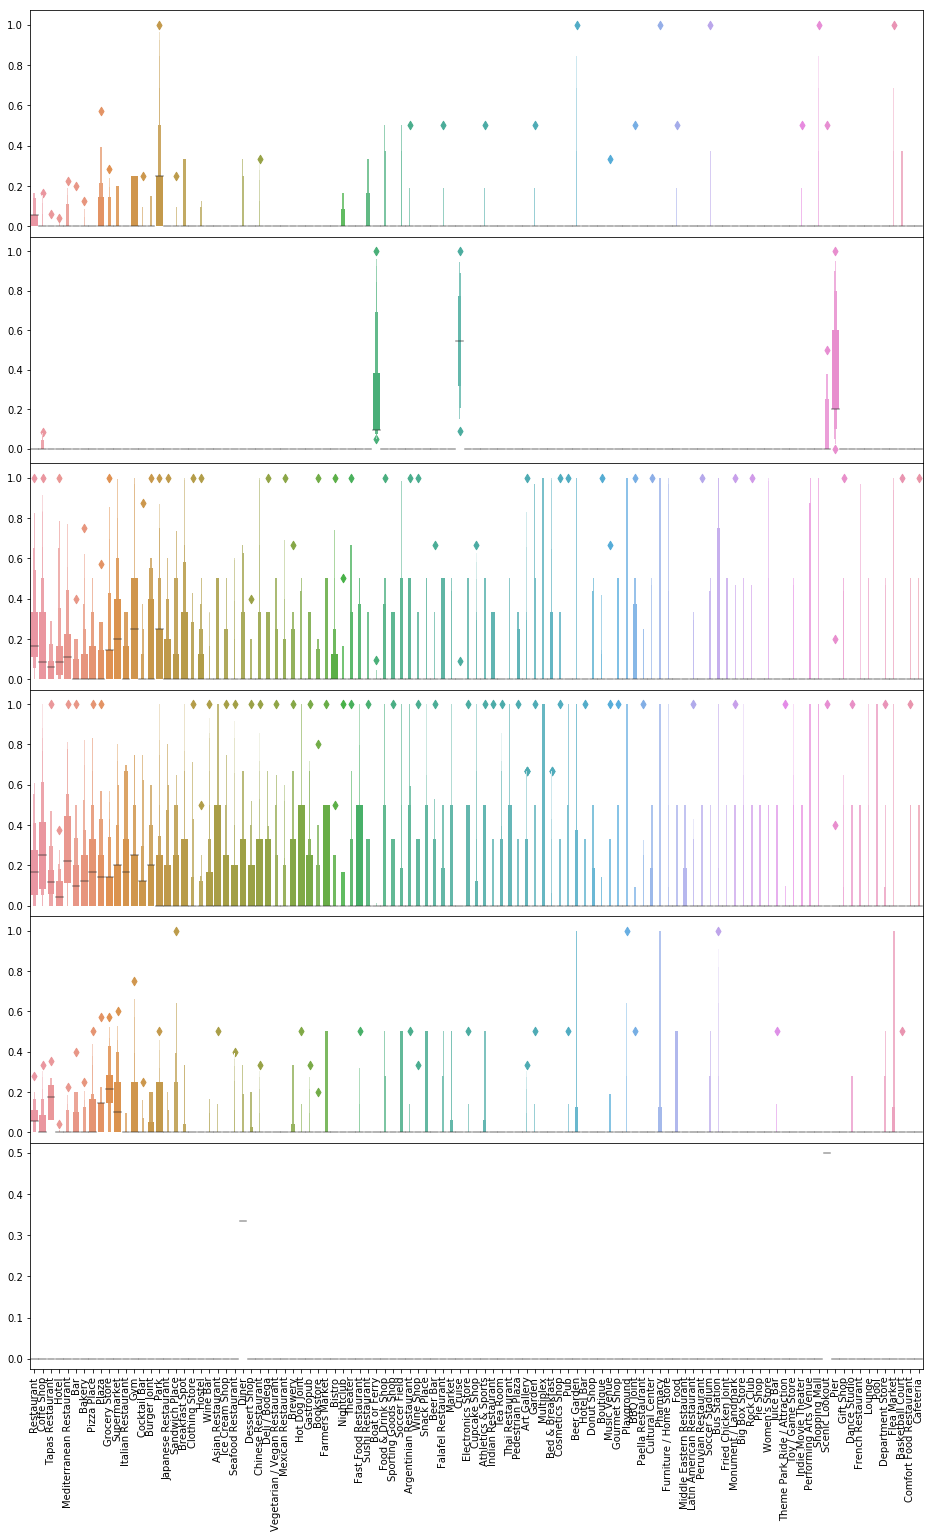

In [180]:
f, axes = plt.subplots(kclusters, 1, figsize=(16, 25), sharex=True)
# Remove horizontal space between axes
f.subplots_adjust(hspace=0)

for i in range(kclusters):
    sns.boxenplot(ax=axes[i],data=barcelona_onehot_sorted[barcelona_onehot_sorted['Cluster Labels'] == i].iloc[:,2:109])

plt.xticks(rotation=90)
plt.show()

In [147]:
cluster = 0
print(barcelona_merged[barcelona_merged['Cluster Labels'] == cluster].shape)
show_in_map(barcelona_merged[barcelona_merged['Cluster Labels'] == cluster], kclusters)

(13, 16)


In [148]:
cluster = 1
print(barcelona_merged[barcelona_merged['Cluster Labels'] == cluster].shape)
show_in_map(barcelona_merged[barcelona_merged['Cluster Labels'] == cluster], kclusters)

(5, 16)


In [181]:
barcelona_merged[barcelona_merged['Cluster Labels'] == 1]

,Longitude,Latitude,line,name,station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
222,2.173815,41.364315,Estació Marítima Grimaldi Lines,Estació Marítima Grimaldi Lines,Estació Marítima Grimaldi Lines/Estació Maríti...,1,Boat or Ferry,Board Shop,Cruise,Scenic Lookout,Food Stand,Food Court,Event Service,Event Space,Exhibit,Fabric Shop
400,2.178511,41.356658,Terminal Marítima A *Creuers,Terminal Marítima A *Creuers,Terminal Marítima A *Creuers/Terminal Marítima...,1,Boat or Ferry,Cruise,Pier,Film Studio,Event Service,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market
564,2.179963,41.360193,Terminal Marítima C *Creuers,Terminal Marítima C *Creuers,Terminal Marítima C *Creuers/Terminal Marítima...,1,Boat or Ferry,Cruise,Pier,Surf Spot,Event Service,Food & Drink Shop,Food,Food Stand,Event Space,Exhibit
646,2.175248,41.352808,Terminal Marítima E *Creuers,Terminal Marítima E *Creuers,Terminal Marítima E *Creuers/Terminal Marítima...,1,Cruise,Boat or Ferry,Pier,Port,Hot Dog Joint,Hostel,Empanada Restaurant,Ethiopian Restaurant,Event Service,Event Space
648,2.174767,41.350955,Terminal Marítima D *Creuers,Terminal Marítima D *Creuers,Terminal Marítima D *Creuers/Terminal Marítima...,1,Cruise,Boat or Ferry,Coffee Shop,Pier,Port,Hostel,Hockey Arena,Electronics Store,Empanada Restaurant,Ethiopian Restaurant


In [149]:
cluster = 2
print(barcelona_merged[barcelona_merged['Cluster Labels'] == cluster].shape)
show_in_map(barcelona_merged[barcelona_merged['Cluster Labels'] == cluster], kclusters)

(12, 16)


In [152]:
cluster = 3
print(barcelona_merged[barcelona_merged['Cluster Labels'] == cluster].shape)
show_in_map(barcelona_merged[barcelona_merged['Cluster Labels'] == cluster], kclusters)

(125, 16)


In [159]:
cluster = 6
print(barcelona_merged[barcelona_merged['Cluster Labels'] == cluster].shape)
show_in_map(barcelona_merged[barcelona_merged['Cluster Labels'] == cluster], kclusters)

(2, 16)


In [160]:
barcelona_merged[barcelona_merged['Cluster Labels'] == cluster]

,Longitude,Latitude,line,name,station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
171,2.111267,41.409124,Funicular VALLVIDRERA,inferior,inferior/Funicular VALLVIDRERA,6,Scenic Lookout,Trail,Diner,Empanada Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Falafel Restaurant
315,2.110914,41.409282,FGC,PEU FUNICULAR,PEU FUNICULAR/FGC,6,Scenic Lookout,Trail,Diner,Empanada Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Falafel Restaurant
